In [74]:
%precision 3
import numpy as np
import pandas as pd
from IPython import display
from pathlib import Path
from scipy import stats
from sklearn import preprocessing, decomposition, linear_model
from matplotlib import pyplot as plt, ticker, lines, patches
plt.style.use("minimal")

In [75]:
METADATA_LINES      = 9                         # number of lines to skip in logfile
SPATIAL_SCALE       = 1000                      # spatial measurements were recorded in millimeters
SAMPLE_RATE         = 300                       # Hz (samples/second)
DISPATCH_MARGIN     = 0.4                       # time before dispatch to consider (seconds)
BRIM_OFFSET         = 1.6                       # cup marker plane to cup brim plane in cm
CUP_RADIUS          = 4.6                       # radius of cup in cm
BALL_RADIUS         = 0.95                      # radius of ball marker
HIT_RADIUS          = CUP_RADIUS - BALL_RADIUS  # distance max for a ball to have been within cup
DATA_PATH           = Path("../Data")           # path to measurement directories
SHOWCASE_PATH       = Path("../Showcase")       # path to showcase export directory
SELECTED_MARKERS    = ["Ball", "CupCentroid", "Belt", "Neck", "ShoulderDominant", "Elbow", "Wrist", "HandDorsum", "FingerIndex", "FingerThumb"]

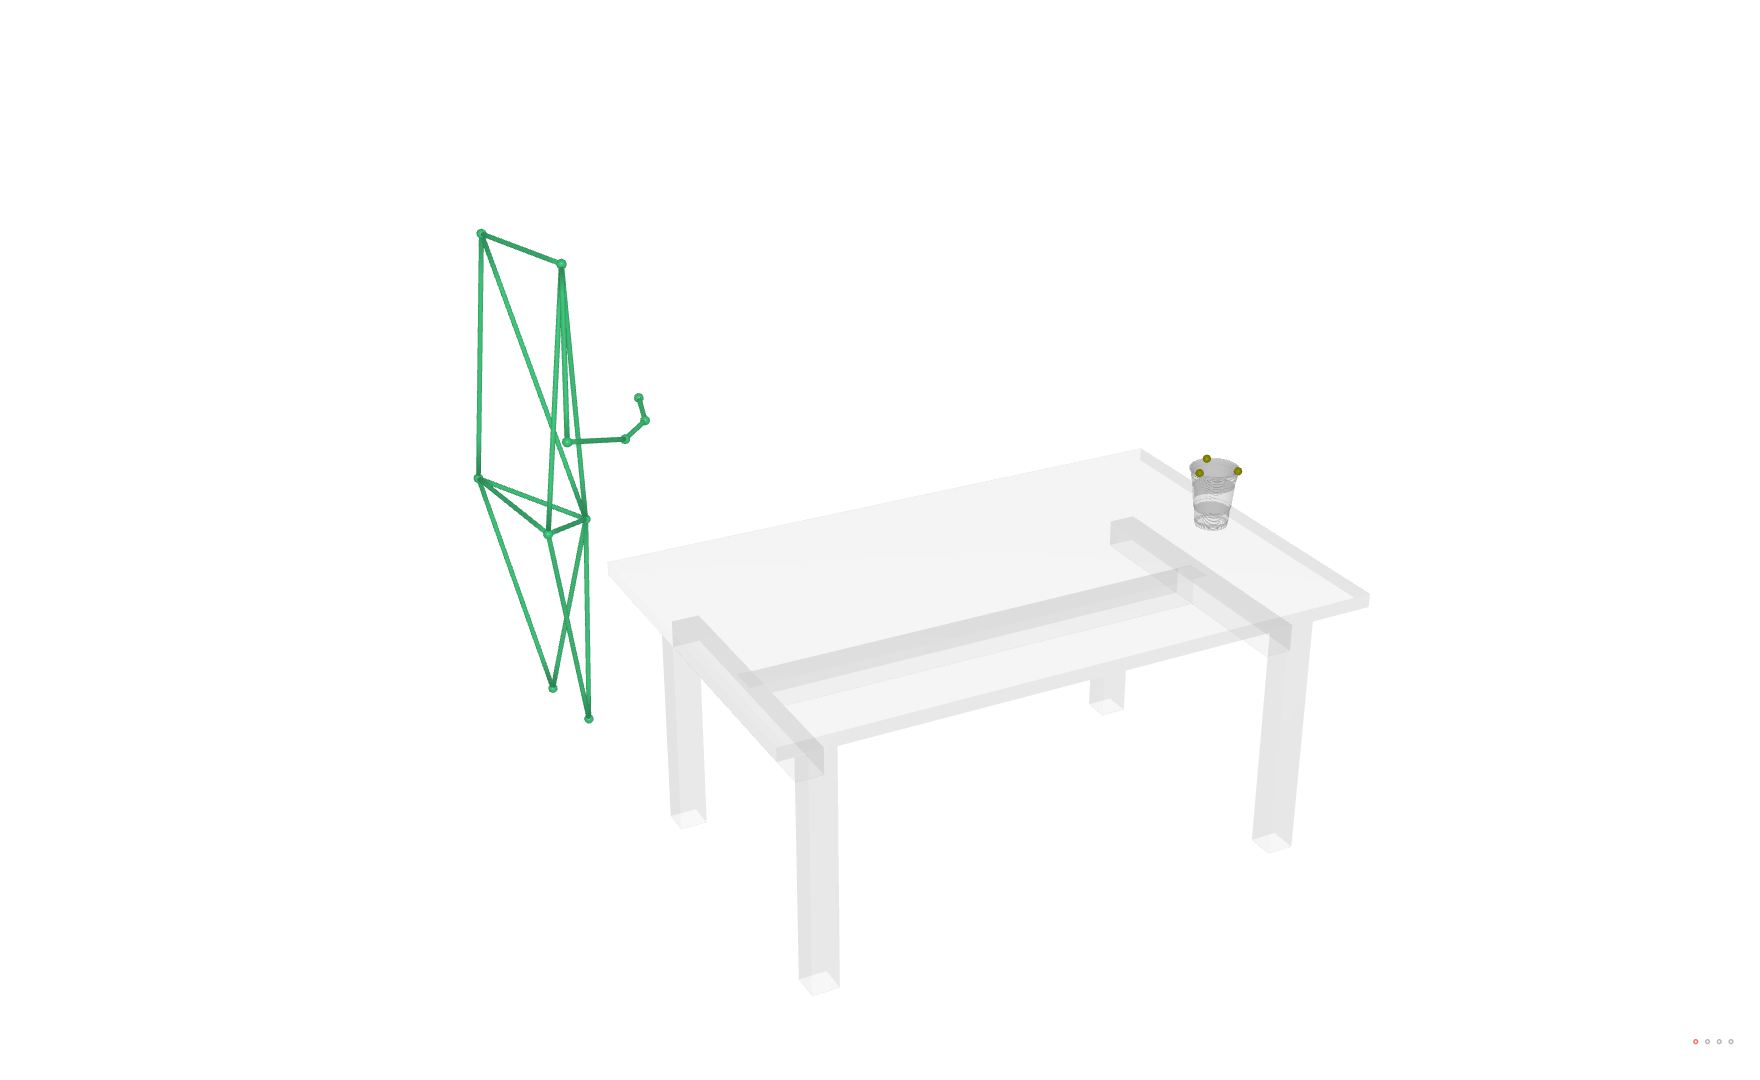

In [76]:
display.Image(SHOWCASE_PATH.joinpath("showcase.gif"))

---

# Preprocessing

In [552]:
class Recording(pd.Series):
    def __init__(self, path):
        trials = []
        for trial, segment in self.read_datafile(path).groupby("Trial"):
            segment["Time"] -= segment["Time"].min()
            trials.append(Trial(segment))

        pd.Series.__init__(self, data = trials, index = np.arange(1, len(trials) + 1), name = "Trial")

    def read_datafile(self, path):
        events = pd.read_csv(
            path, 
            sep = "\t", 
            header = None, 
            names = ("Type", "EventType", "Frame", "Time"), 
            skiprows = METADATA_LINES, 
            on_bad_lines = "skip"
        )

        recorded_data = pd.read_csv(
            path, 
            sep = "\t", 
            header = METADATA_LINES + len(events) + 2, 
            usecols = lambda name: "Unnamed" not in name
        )[["Time"] + [f"{marker} {axis}" for axis in ["X", "Y", "Z"] for marker in SELECTED_MARKERS]]

        recorded_data = recorded_data.set_index("Time")
        recorded_data.columns = recorded_data.columns.str.split(" ", expand = True)
        recorded_data = recorded_data.stack(0, dropna = False)
        recorded_data.index = recorded_data.index.rename(["Time", "Marker"])
        recorded_data = recorded_data.reset_index()

        recorded_data["TrialTag"] = recorded_data["Time"].isin(events[events["EventType"] == "Trial"]["Time"])
        recorded_data["Trial"] = (recorded_data["TrialTag"].astype(int).diff() > 0).cumsum()
        recorded_data = recorded_data[recorded_data["Trial"] > 0]

        return recorded_data

    def __repr__(self):
        return f"[Recording ({len(self)} trials)]"

class Trial(pd.Series):
    def __init__(self, data, *args, **kwargs):
        pd.Series.__init__(self, {marker: self.process_marker_data(data) for marker, data in tuple(data.groupby("Marker", as_index = False))}, *args, **kwargs)
        self.enhance()
        self.determine_outcome()

    def process_marker_data(self, marker_data):
        data = marker_data[["Time", "X", "Y", "Z"]]
        data = data.set_index("Time")
        data = data.interpolate(limit_direction = "both")
        data = (data / SPATIAL_SCALE) * 100 # rescale from mm to cm
        return data.reset_index()

    def calculate_speed(self, subset):
        delta_pos = (subset[["X", "Y", "Z"]].shift(1).values - subset[["X", "Y", "Z"]].values) * SAMPLE_RATE
        speed = np.sqrt(np.sum(delta_pos ** 2, axis = 1))
        speed = pd.Series(speed).rolling(int(SAMPLE_RATE / 10)).mean() # smoothen with rolling average
        speed /= 100 # rescale from cm/s to m/s
        return speed

    def calculate_acceleration(self, subset):
        return (subset["Speed"].diff() / SAMPLE_RATE).rolling(int(SAMPLE_RATE / 10)).mean() # smoothen with rolling average

    def sync_and_trim(self, subset, reference_timepoint, pre = None, post = None):
        if pre and post:
            subset = subset[(subset["Time"] > reference_timepoint - pre) & (subset["Time"] < reference_timepoint + post)].copy()
        subset["Time"] -= subset["Time"].min()
        subset.index -= subset.index.min()
        return subset

    def recenter_to_cup_centroid(self, subset):
        cup_centroid = self["CupCentroid"].iloc[0][["X", "Y", "Z"]]
        cup_centroid["Z"] += BRIM_OFFSET
        subset[["X", "Y", "Z"]] = subset[["X", "Y", "Z"]].subtract(cup_centroid)
        return subset

    def enhance(self):
        # adding derived measures
        for marker in self.index:
            self.recenter_to_cup_centroid(self[marker])
            self[marker]["Speed"] = self.calculate_speed(self[marker])
            self[marker]["Acceleration"] = self.calculate_acceleration(self[marker])

        # trimming to throw by using max ball speed (terminal velocity)
        reference_timepoint = self["Ball"]["Time"][self["Ball"]["Speed"].replace(np.nan, 0).idxmax()]
        for marker in self.index:
            self[marker] = self.sync_and_trim(
                self[marker], 
                reference_timepoint, 
                pre = 1, 
                post = DISPATCH_MARGIN
            )

        # trimming and "centering" around throw movement instead of terminal velocity
        reference_timepoint = self["Ball"]["Time"][self["Ball"]["Acceleration"].replace(np.nan, 0).idxmax()]
        for marker in self.index:
            self[marker] = self.sync_and_trim(
                self[marker], 
                reference_timepoint, 
                pre = DISPATCH_MARGIN, 
                post = 0.6
            )
    
    def ball_distance_to_cup_centroid(self):
        return pd.DataFrame(dict(
            Time = self["Ball"]["Time"], 
            Distance = np.sqrt(np.sum((self["Ball"][["X", "Y"]].values - self["CupCentroid"][["X", "Y"]].values)**2, axis = 1))
        ))
    
    def determine_outcome(self):
        self.outcome = ((self["Ball"]["Z"] <= 0) & (self["Ball"]["Z"] >= -1.5) & (self.ball_distance_to_cup_centroid()["Distance"] <= (CUP_RADIUS - BALL_RADIUS))).any()

    def __repr__(self):
        return f"[Trial] {'Hit' if self.outcome else 'Miss'}"

class Session(pd.DataFrame):
    def __init__(self, session_id, session_data):
        pd.DataFrame.__init__(self, session_data)
        self.session_id = session_id

    def __repr__(self):
        return f"[Session {self.session_id}]"

class Dataset(pd.Series):
    def __init__(self):
        sessions = []
        for session_path in Path(DATA_PATH).iterdir():
            if session_path.name.startswith("Session"):
                session_id = int(session_path.name[7:])
                if session_id != 6:
                    continue
                recording_data = []
                for recording_path in session_path.iterdir():
                    if recording_path.suffix == ".tsv":
                        player_id = int(recording_path.name[6])
                        condition = recording_path.stem.split("_")[1]
                        print("[LOADING]", "Session", session_id, "Player", player_id, condition)
                        recording_data.append(dict(
                            Player = player_id,
                            Condition = condition,
                            Recording = Recording(recording_path)
                        ))
                sessions.append(Session(session_id, recording_data))

        pd.Series.__init__(self, sorted(sessions, key = lambda session: session.session_id), index = range(1, len(sessions) + 1))

    def __repr__(self):
        return f"""[Dataset ({len([session for session in self if len(session)])} sessions: {", ".join([str(session.session_id) for session in self if len(session)])})]"""

In [78]:
dataset = Dataset()
print(dataset)

[LOADING] Session 1 Player 1 Darkness


[LOADING] Session 1 Player 1 Daylight
[LOADING] Session 1 Player 2 Darkness
[LOADING] Session 1 Player 2 Daylight
[LOADING] Session 10 Player 1 Darkness
[LOADING] Session 10 Player 1 Daylight
[LOADING] Session 10 Player 2 Darkness
[LOADING] Session 10 Player 2 Daylight
[LOADING] Session 11 Player 1 Darkness
[LOADING] Session 11 Player 1 Daylight
[LOADING] Session 11 Player 2 Darkness
[LOADING] Session 11 Player 2 Daylight
[LOADING] Session 12 Player 1 Darkness
[LOADING] Session 12 Player 1 Daylight
[LOADING] Session 12 Player 2 Darkness
[LOADING] Session 12 Player 2 Daylight
[LOADING] Session 13 Player 1 Darkness
[LOADING] Session 13 Player 1 Daylight
[LOADING] Session 13 Player 2 Darkness
[LOADING] Session 13 Player 2 Daylight
[LOADING] Session 14 Player 1 Darkness
[LOADING] Session 14 Player 1 Daylight
[LOADING] Session 14 Player 2 Darkness
[LOADING] Session 14 Player 2 Daylight
[LOADING] Session 2 Player 1 Darkness
[LOADING] Session 2 Player 1 Daylight
[LOADING] Session 2 Player 2 D

C:\Users\dl\AppData\Local\Temp\ipykernel_18240\1239851080.py:20: DtypeWarning: Columns (33,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  recorded_data = pd.read_csv(


[LOADING] Session 7 Player 2 Darkness
[LOADING] Session 7 Player 2 Daylight
[LOADING] Session 8 Player 1 Darkness
[LOADING] Session 8 Player 1 Daylight
[LOADING] Session 8 Player 2 Darkness
[LOADING] Session 8 Player 2 Daylight
[LOADING] Session 9 Player 1 Darkness
[LOADING] Session 9 Player 1 Daylight
[LOADING] Session 9 Player 2 Darkness
[LOADING] Session 9 Player 2 Daylight
[Dataset (14 sessions: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)]


---

# Visualization

In [553]:
SELECTED_SESSION    = dataset[6]
PERFORM_EXPORT      = True

In [530]:
def annotate_metadata():
    plt.annotate(f"Session {SELECTED_SESSION.session_id}", xy = (1, 0.01), xycoords = ("axes fraction", "figure fraction"), ha = "right", va = "bottom", alpha = 0.5)

def mark_dispatch():
    plt.axvline(DISPATCH_MARGIN, color = "black", linestyle = "--", linewidth = 1, alpha = 0.05, zorder = -1)

def decorate_xaxis_ticks():
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.gca().xaxis.set_major_formatter(lambda val, idx: int(val * 1000))
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.05))

In [554]:
def plot_trajectory(marker, dimension):
    plt.figure()
    mark_dispatch()
    plt.annotate(
        f"Session {SELECTED_SESSION.session_id}", 
        xy = (0, 0.95), 
        xycoords = ("axes fraction", "figure fraction"), 
        horizontalalignment = "left", 
        verticalalignment = "top", 
        alpha = 0.8, 
        in_layout = False
    )
    for index, (player, condition, recording) in SELECTED_SESSION.iterrows():
        for trial, subset in recording.items():
            plt.plot(
                subset[marker]["Time"],
                subset[marker][dimension], 
                color = "C0" if player == 1 else "C2",
                linewidth = 0.6, 
                linestyle = "-" if subset.outcome else ":",
                alpha = 0.2
            )

    dimension = dimension if not dimension == "Z" else "Altitude"
    plt.title(f"{marker} {dimension}\n")
    plt.xlabel("Time (ms)")
    if dimension == "Speed":
        plt.ylabel(f"{dimension} (m/s)")
    elif dimension == "Acceleration":
        plt.ylabel(f"{dimension} (m/s$^2$)")
    else:
        plt.ylabel("Displacement (cm)")

    decorate_xaxis_ticks()
    plt.legend(
        handles = [lines.Line2D([0], [0], color=color, linewidth = 0.6) for color in ("C0","C2")], 
        labels = ["Player 1", "Player 2"], 
        loc = "upper center", 
        bbox_to_anchor = (0.5, 1.1), 
        ncol = 2,
    )
    plt.margins(x = 0, y = 0.05)
    plt.tight_layout()
    if PERFORM_EXPORT:
        plt.savefig(SHOWCASE_PATH.joinpath(f"{marker}_{dimension}.png"), dpi = 300, bbox_inches = "tight")

def plot_round_target():
    figure, axes = plt.subplots(figsize = (6.5, 4.5), ncols=2, width_ratios=[4.5, 2], gridspec_kw = dict(wspace = 0))
    disc_ax, aggregated_ax = axes

    disc_ax.spines["left"].set(zorder = -1)
    disc_ax.spines["bottom"].set(zorder = -1)
    disc_ax.spines["left"].set_position("center")
    disc_ax.spines["bottom"].set_position("center")
    # cup brim
    disc_ax.add_patch(patches.Circle((0, 0), 4.6, color="red", alpha = 0.1))
    disc_ax.add_patch(patches.Circle((0, 0), 4.6, color="red", alpha = 0.8, fill = False, linewidth = 2))
    # base of cup
    disc_ax.add_patch(patches.Circle((0, 0), 2.85, color="white", alpha = 0.4))
    disc_ax.add_patch(patches.Circle((0, 0), 2.85, color="white", alpha = 0.8, fill = False, linewidth = 1))
    # target disc levels
    for radius in (5, 10, 15):
        disc_ax.add_patch(patches.Circle((0, 0), radius + HIT_RADIUS, color="black", fill = False, alpha = 0.1))

    points = []
    for index, (player, condition, recording) in SELECTED_SESSION.iterrows():
        for trial, trial_data in recording.items():
            ball_under_cup_plane = trial_data["Ball"][trial_data["Ball"]["Z"] <= 0.2].iloc[0] if trial_data["Ball"]["Z"].min() <= 0.2 else trial_data["Ball"].iloc[trial_data["Ball"]["Z"].idxmax()]

            touchdown_point = ball_under_cup_plane[["X", "Y"]] # point at which ball crosses transverse plane of cup
            points.append(dict(
                Player = player,
                Trial = trial,
                Condition = condition,
                Outcome = trial_data.outcome,
                Lateral = touchdown_point["Y"], # in the coordinate system of the recording, the Y-axis is lateral
                Longitude = touchdown_point["X"],
            ))

    zoom_range = 20
    landing_spots = pd.DataFrame(points)
    landing_spots["Distance"] = np.sqrt((landing_spots[["Lateral", "Longitude"]]**2).sum(axis = 1))

    for index, point in landing_spots[landing_spots["Distance"] <= zoom_range].iterrows():
        disc_ax.add_patch(plt.Circle(
            (point["Lateral"], point["Longitude"]),
            radius = BALL_RADIUS, 
            color = "C0" if point["Player"] == 1 else "C2",
            linewidth = 0,
            alpha = 0.9,
        ))
        disc_ax.add_patch(plt.Circle(
            (point["Lateral"], point["Longitude"]),
            radius = 0.2, 
            color = "white" if point["Condition"] == "Daylight" else "black",
            linewidth = 0,
            alpha = 0.4
        ))
        disc_ax.annotate(
            point["Trial"],
            (point["Lateral"], point["Longitude"]),
            fontsize = 5,
            textcoords = "offset points",
            color = "white" if point["Condition"] == "Daylight" else "black",
            horizontalalignment = "center",
            xytext=(0, 2), 
        )

    # disc_ax.set_title("Landing Spots\n\n")
    disc_ax.set_xlim((-zoom_range, zoom_range))
    disc_ax.set_ylim((-zoom_range, zoom_range))

    disc_ax.set_xticks(
        [-(HIT_RADIUS + val) for val in range(5, 20, 5)] + [HIT_RADIUS + val for val in range(5, 20, 5)], 
        3 * [""] + [str(val) + " cm" for val in range(5, 20, 5)]
    )
    disc_ax.set_yticks(
        [-(HIT_RADIUS + val) for val in range(5, 20, 5)] + [HIT_RADIUS + val for val in range(5, 20, 5)], 
        6 * [""]
    )
    disc_ax.grid(False)
    disc_ax.set_aspect("equal")

    landing_spots[["Distance", "Lateral", "Longitude"]] = landing_spots[["Distance", "Lateral", "Longitude"]].apply(lambda vals: vals - HIT_RADIUS, axis = 1).clip(lower = 0)
    measures = landing_spots.groupby("Player").agg(**{
        "Mean dist. (SD)": ("Distance", lambda vals: f"{vals.mean():.1f} ({vals.std():.1f}) cm"),
        "Median dist. (MAD)": ("Distance", lambda vals: f"{vals.median():.1f} ({np.median(np.absolute(vals - np.median(vals))):.1f}) cm"),
        "Mean lateral (SD)": ("Lateral", lambda vals: f"{vals.mean():.1f} ({vals.std():.1f}) cm"),
        "Mean longitude (SD)": ("Longitude", lambda vals: f"{vals.mean():.1f} ({vals.std():.1f}) cm"),
        "Most severe miss": ("Distance", lambda vals: f"{vals.max():.1f} cm"),
        "Shots into cup": ("Outcome", lambda vals: f"{vals.sum()}"),
        "Brim hits": ("Distance", lambda vals: f"{(vals <= BALL_RADIUS).sum()}"),
        "Shots left of cup": ("Lateral", lambda vals: f"{(vals < 0).sum()}"),
        "Shots right of cup": ("Lateral", lambda vals: f"{(vals > 0).sum()}"),
        "Shots too deep": ("Longitude", lambda vals: f"{(vals > 0).sum()}"),
        "Shots too short": ("Longitude", lambda vals: f"{(vals < 0).sum()}"),
    }).T

    disc_ax.legend(
        handles = [lines.Line2D([0], [0], marker = "o", color=color, markersize = 12, linewidth=0) for color in ("C0", "C2")], 
        labels = [f"Player {player_id}" for player_id in measures.columns], 
        loc = "upper center",
        bbox_to_anchor = (0.5, 1.1),
        ncol = 2,
    )

    table = aggregated_ax.table(
        measures.values,
        rowLabels = measures.index,
        rowColours = ["#fafafa"] * len(measures.index),
        colLabels = [f"Player {player_id}" for player_id in measures.columns],
        colLoc = "center",
        colColours = ["#fafafa"] * len(measures.columns),
        cellLoc = "center",
        loc = "center",
        bbox = (0.5, 0, 0.8, 1)
    )
    table.auto_set_font_size(False)
    table.set_fontsize(5)
    for (row, col), cell in table.get_celld().items():
        cell.set_linewidth(0.02)
        if row == 0 or col == -1:
            cell.set_text_props(fontproperties=dict(weight = 500))
    aggregated_ax.axis("off")

    plt.tight_layout()
    if PERFORM_EXPORT:
        plt.savefig(SHOWCASE_PATH.joinpath("landing_spot.png"), dpi = 300, bbox_inches = "tight")

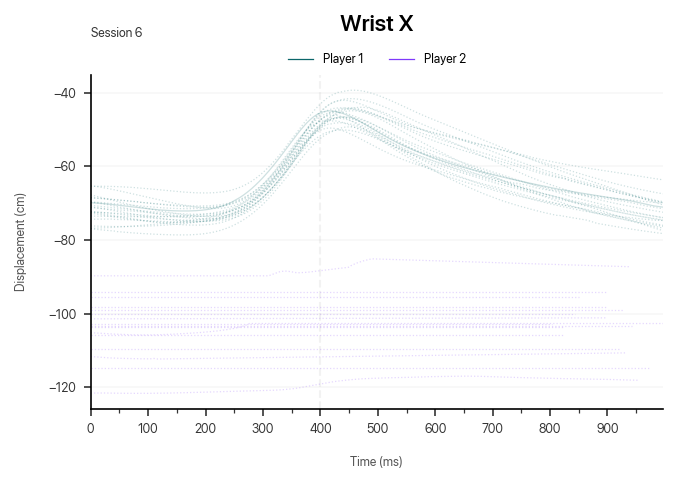

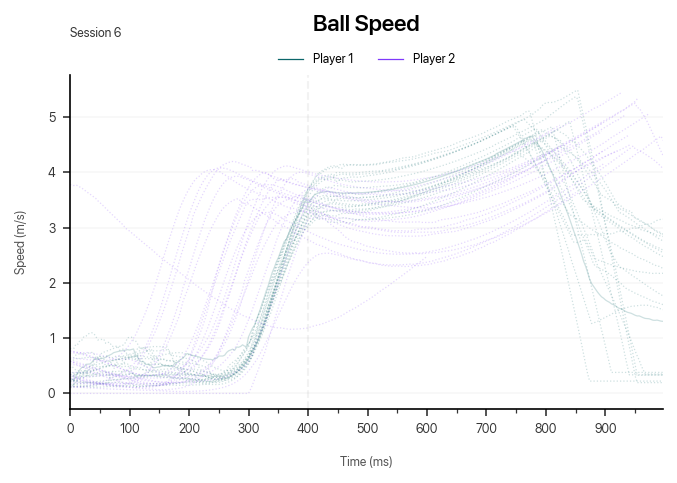

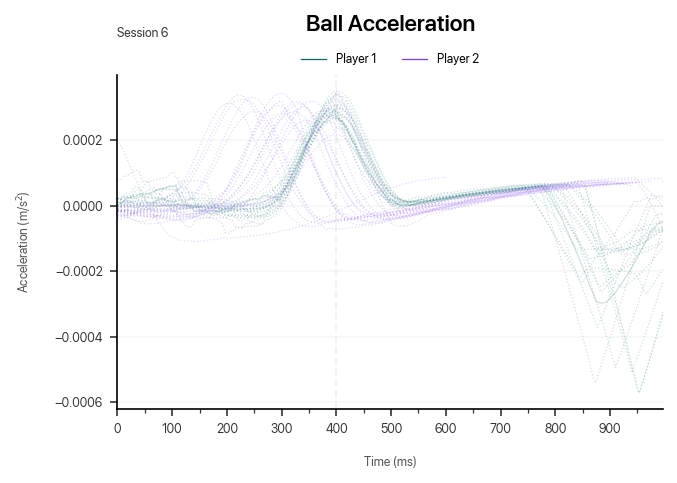

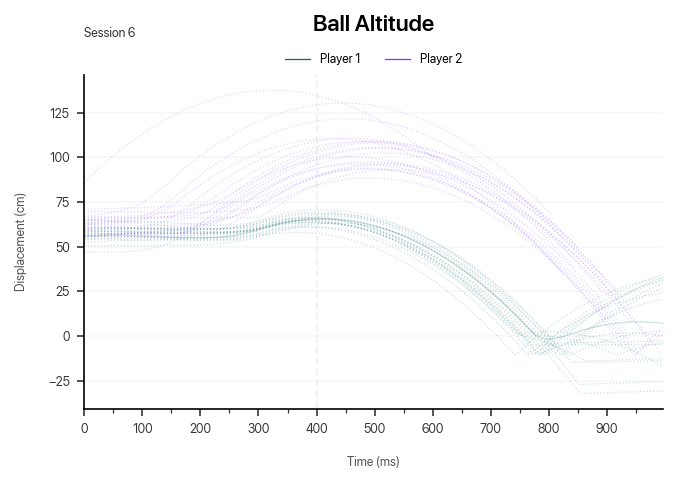

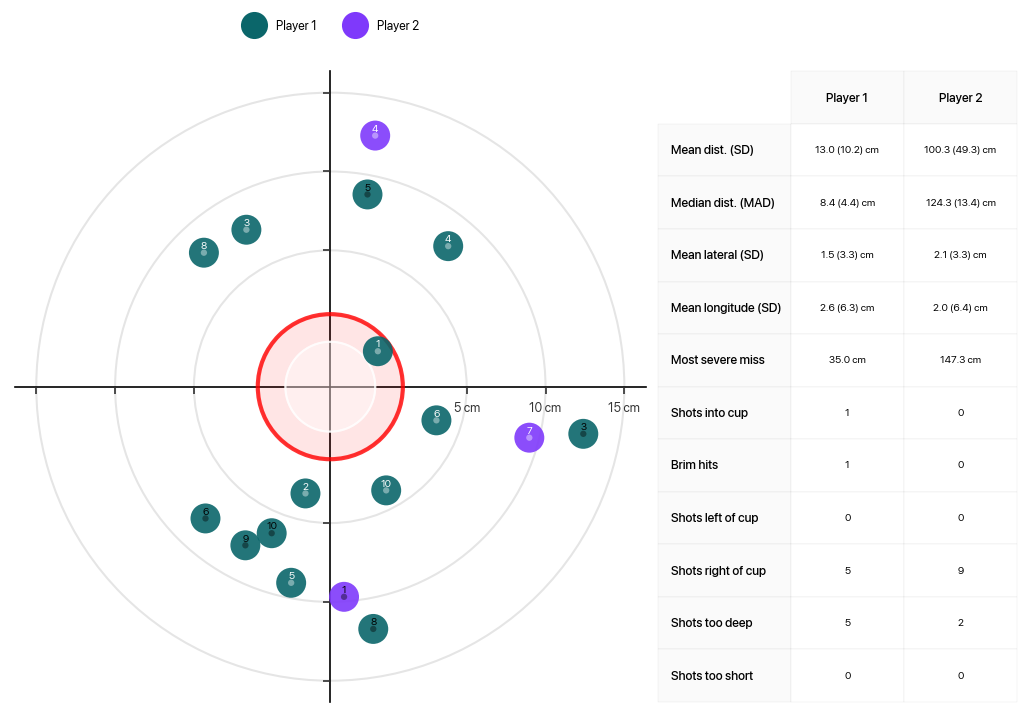

In [555]:
plot_trajectory(marker = "Wrist", dimension = "X")
plot_trajectory(marker = "Ball", dimension = "Speed")
plot_trajectory(marker = "Ball", dimension = "Acceleration")
plot_trajectory(marker = "Ball", dimension = "Z")
plot_round_target()

In [551]:
def aggregate():
    sessions = []
    for session, session_data in dataset.items():
        session_summaries = []
        for index, (player_id, condition, recording) in session_data.iterrows():
            for trial, trial_data in recording.items():
                try:
                    ball_data = trial_data["Ball"]
                    ball_data["Distance"] = np.sqrt((ball_data[["X", "Y", "Z"]] ** 2).sum(axis = 1))
                    ball_data["DistanceHorizontal"] = np.sqrt((ball_data[["X", "Y"]] ** 2).sum(axis = 1))

                    above_brim_plane = (ball_data["Z"] >= 2) & (ball_data["Z"].shift(-1) < 2)
                    # above_brim_plane = (ball_data["Z"].shift(1) > 2) & (ball_data["Z"] <= 2)
                    # print(ball_data[above_brim_plane]["DistanceHorizontal"])
                    ball_data["Lateral"] = ball_data["Y"] # in the coordinate system of the recording, the Y-axis is lateral
                    ball_data["Longitude"] = ball_data["X"]

                    session_summaries.append({
                        "Session": session,
                        "Player": player_id, 
                        "Condition": "Dark room" if condition == "Darkness" else "Lit room", 
                        "Trial": trial, 
                        "CompletedThrows": trial if condition == "Darkness" else trial + 10,
                        "Outcome": "Hit" if trial_data.outcome else "Miss",
                        "RadialError": ball_data[above_brim_plane]["DistanceHorizontal"].iloc[0], # minimum distance from cup centroid in cm
                        # "DistanceMiss": max(0, ball_data[above_brim_plane]["Distance"].iloc[0] - HIT_RADIUS), # minimum distance from cup in cm
                        # "LateralMiss": max(0, abs(ball_data[above_brim_plane]["Lateral"]).min() - HIT_RADIUS), # lateral distance to cup in cm
                        # "LongitudeMiss": max(0, abs(ball_data[above_brim_plane]["Longitude"]).min() - HIT_RADIUS), # longitudinal distance to cup in cm
                        # "BallSpeedMax": ball_data["Speed"].max(), # ball max speed in m/s
                        # "BallAltitudeMax": ball_data["Z"].max(), # ball max altitude in cm
                        # "WristSpeedMax": trial_data["Wrist"]["Speed"].max(), # wrist max speed in m/s
                        # "DispatchDistance": -ball_data.iloc[int(DISPATCH_MARGIN * SAMPLE_RATE)]["X"], # distance to cup in cm at moment of dispatch 
                        # "DispatchElbowAltitude": trial_data["Elbow"]["Z"].loc[ball_data["Speed"].idxmax()], # height of elbow in cm at time of dispatch
                    })
                except:
                    print(f"Failed to aggregate trial {trial} in session {session} {player_id} {condition}")
        sessions.append(pd.DataFrame(session_summaries))

    results = pd.concat(sessions, ignore_index = True)
    results.insert(2, "Participant", results.groupby(["Session", "Player"]).ngroup() + 1)
    return results

aggregated = aggregate()
aggregated.to_csv("aggregated.csv", index = False)
aggregated.set_index(["Session", "Player", "Condition", "Trial"]).round(2).head(10)

Failed to aggregate trial 3 in session 6 2 Darkness
Failed to aggregate trial 4 in session 6 2 Darkness
Failed to aggregate trial 5 in session 6 2 Darkness
Failed to aggregate trial 6 in session 6 2 Darkness
Failed to aggregate trial 8 in session 6 2 Darkness
Failed to aggregate trial 9 in session 6 2 Darkness
Failed to aggregate trial 10 in session 6 2 Darkness
Failed to aggregate trial 1 in session 6 2 Daylight
Failed to aggregate trial 2 in session 6 2 Daylight
Failed to aggregate trial 3 in session 6 2 Daylight
Failed to aggregate trial 5 in session 6 2 Daylight
Failed to aggregate trial 6 in session 6 2 Daylight
Failed to aggregate trial 8 in session 6 2 Daylight
Failed to aggregate trial 9 in session 6 2 Daylight


Participant  CompletedThrows Outcome  \
Session Player Condition Trial                                         
1       1      Dark room 1                1                1    Miss   
                         2                1                2    Miss   
                         3                1                3    Miss   
                         4                1                4    Miss   
                         5                1                5    Miss   
                         6                1                6     Hit   
                         7                1                7    Miss   
                         8                1                8    Miss   
                         9                1                9    Miss   
                         10               1               10    Miss   

                                RadialError  
Session Player Condition Trial               
1       1      Dark room 1            10.18  
                         2             5.05  
                         3             8.80  
                         4             8.86  
                         5            11.55  
                         6             3.74  
                         7            11.51  
                         8             9.71  
                         9            11.13  
                         10           11.16

---

# Analysis

In [558]:
OUTCOME_METRIC = "RadialError"

aggregated["LogRadialError"] = np.log(aggregated[OUTCOME_METRIC])

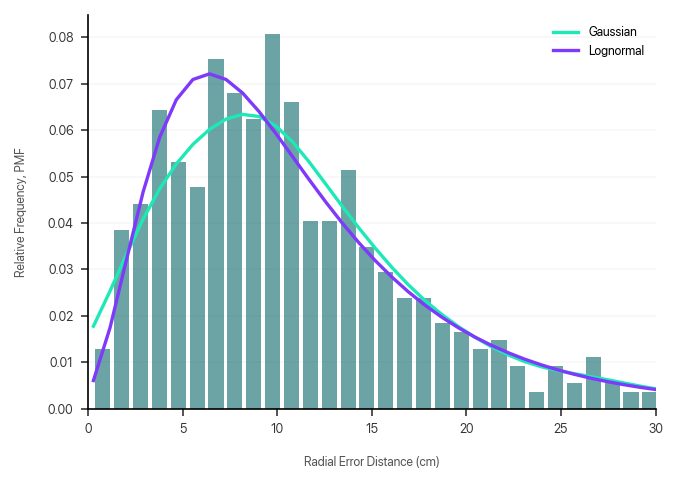

In [556]:
def plot_outcome_distribution():
    plt.figure()
    data_range = aggregated["RadialError"].min(), aggregated["RadialError"].max()
    x_range = np.linspace(*data_range, num = 100)
    plt.hist(
        aggregated["RadialError"],
        range = data_range, 
        bins = round(data_range[1] - data_range[0]),
        density=True, 
        alpha = 0.6,
        rwidth=0.8
    )
    plt.plot(
        x_range, 
        stats.gaussian_kde(aggregated["RadialError"])(x_range),
        label = "Gaussian"
    )
    lognorm_shape, lognorm_loc, lognorm_scale = stats.lognorm.fit(aggregated["RadialError"])
    plt.plot(
        x_range, 
        stats.lognorm.pdf(x_range, lognorm_shape, lognorm_loc, lognorm_scale),
        label = "Lognormal"
    )
    plt.xlabel("Radial Error Distance (cm)")
    plt.ylabel("Relative Frequency, PMF")
    plt.title("")
    plt.legend(loc = "upper right")
    plt.xlim((0, 30))
    # plt.ylim((0, 1))
    plt.tight_layout()

plot_outcome_distribution()

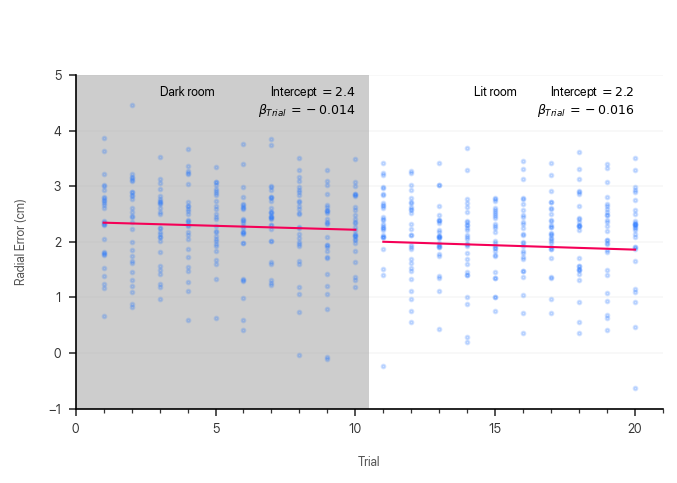

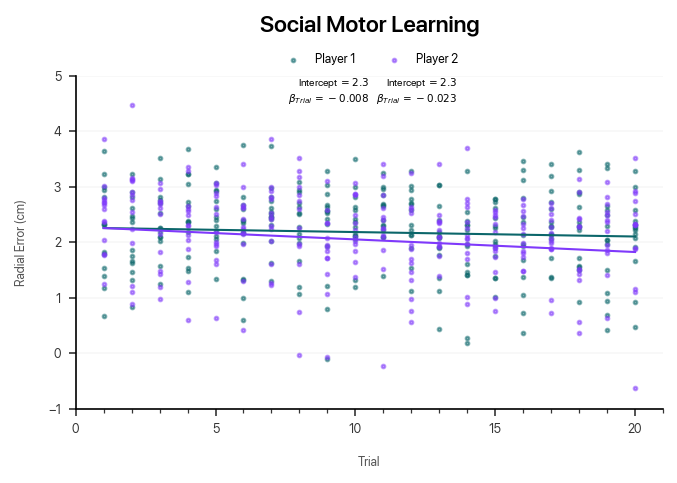

In [560]:
def decorate(title):
    plt.title(title + "\n")
    plt.xlabel("Trial")
    plt.ylabel("Radial Error (cm)")
    plt.xlim((0, 21))
    # plt.ylim((0, 50))
    plt.ylim((-1, 5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(1))
    plt.margins(x = 0.1)

def model_recap(regression_model):
    slope_name = r"$\beta_{Trial}$"
    # return ""
    return f"Intercept $= {regression_model.intercept_:.1f}$\n{slope_name} $ = {regression_model.coef_[0]:.3f}$"

def mark_condition():
    for condition, data in aggregated.groupby("Condition"):
        plt.gca().add_patch(patches.Rectangle((0, -1), 10.5, 100, color = "black", alpha = 0.1, linewidth = 0, zorder = -1))

        plt.annotate(
            condition,
            (data["CompletedThrows"].median() - 1, 0.95), 
            xycoords=("data", "axes fraction"),
            horizontalalignment = "center",
            verticalalignment = "center",
        )

def learning_across_trials():
    plt.figure()
    plt.scatter(
        aggregated["CompletedThrows"], 
        aggregated["LogRadialError"], 
        s = 3,
        color = "C6",
        alpha = 0.2
    )

    reg = linear_model.GammaRegressor(alpha=4).fit(
        np.vstack(aggregated["CompletedThrows"]), 
        aggregated["Outcome"]
    )

    plt.plot(
        aggregated["CompletedThrows"], 
        reg.predict(np.vstack(aggregated["CompletedThrows"])),
        color = "C7",
        linewidth = 1
    )
    plt.annotate(
        model_recap(reg),
        (0.5, 0.92), 
        xycoords="axes fraction",
        horizontalalignment = "center",
        verticalalignment = "center",
    )
    mark_condition()
    decorate("Distance to Cup Centroid Across All Trials")
    plt.tight_layout()

def learning_across_trials_within_condition():
    plt.figure()
    plt.scatter(
        aggregated["CompletedThrows"], 
        aggregated["LogRadialError"], 
        s = 3,
        color = "C6",
        alpha = 0.2
    )

    for condition, data in aggregated.groupby("Condition"):
        reg = linear_model.LinearRegression().fit(
            np.vstack(data["Trial"]), 
            data["LogRadialError"]
        )

        plt.annotate(
            model_recap(reg),
            (data["CompletedThrows"].max(), 0.92), 
            xycoords=("data", "axes fraction"),
            horizontalalignment = "right",
            verticalalignment = "center",
        )

        plt.plot(
            data["CompletedThrows"], 
            reg.predict(np.vstack(data["CompletedThrows"])),
            color = "C7",
            linewidth = 1
        )

    mark_condition()
    # decorate("Distance to Cup Centroid Across Trials Within Condition")
    # decorate("Visuomotor Feedback Effects")
    decorate("")
    plt.tight_layout()
    if PERFORM_EXPORT:
        plt.savefig(SHOWCASE_PATH.joinpath("between_stages_regression.png"), dpi = 300, bbox_inches = "tight")

def learning_by_playing_order():
    plt.figure()
    for player_id, data in aggregated.groupby("Player"):
        plt.scatter(
            data["CompletedThrows"], 
            data["LogRadialError"], 
            s = 3,
            label = f"Player {player_id}",
            color = "C0" if player_id == 1 else "C2",
            alpha = 0.5
        )

        reg = linear_model.LinearRegression().fit(
            np.vstack(data["Trial"]), 
            data["LogRadialError"]
        )

        plt.annotate(
            model_recap(reg),
            (0.5 + (0 if player_id == 1 else 0.15), 1), 
            xycoords="axes fraction",
            horizontalalignment = "right",
            verticalalignment = "top",
            fontsize = 5,
        )

        plt.plot(
            data["CompletedThrows"], 
            reg.predict(np.vstack(data["CompletedThrows"])),
            color = "C0" if player_id == 1 else "C2",
            linewidth = 1
        )

    decorate("Social Motor Learning")
    plt.legend(
            loc = "upper center",
            bbox_to_anchor = (0.5, 1.1),
            ncol = 2,
        )
    plt.tight_layout()

# learning_across_trials()
learning_across_trials_within_condition()
learning_by_playing_order()

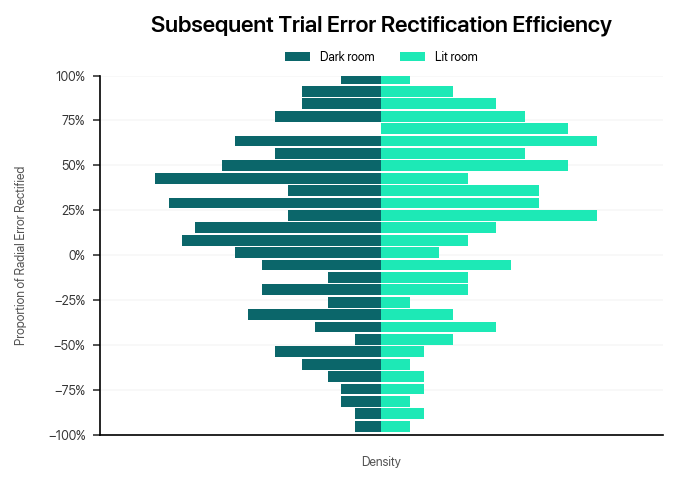

In [376]:
aggregated["Previous"] = aggregated.groupby(["Participant",  "Condition"])[OUTCOME_METRIC].shift()
aggregated["RectificationEfficiency"] = (aggregated["Previous"] - aggregated[OUTCOME_METRIC]) / aggregated["Previous"]
aggregated

plt.figure()

for condition in ("Dark room", "Lit room"):
    amount_bins = 30
    data_range = (-1, 1)
    bin_width = 0.9
    weights, bins = np.histogram(
        aggregated[aggregated["Condition"] == condition]["RectificationEfficiency"].dropna(), 
        bins = amount_bins,
        range = data_range,
        density = True,
    )
    plt.barh(
        np.linspace(*data_range, num = amount_bins) + (1 - bin_width) / 2, 
        weights * (-1 if condition == "Dark room" else 1),
        height = np.diff(bins)[0] * bin_width,
        label = condition
    )

plt.legend(
    loc = "upper center", 
    bbox_to_anchor = (0.5, 1.1), 
    ncol = 2,
)
plt.xlabel("Density")
plt.ylabel("Proportion of Radial Error Rectified")
plt.title("Subsequent Trial Error Rectification Efficiency\n")
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.xticks([])
plt.ylim((-1, 1))
plt.xlim((-1.5, 1.5))
plt.grid(True, which = "both", axis = "y")
plt.tight_layout()

In [164]:
def expand_positional_data(marker_data):
    return pd.concat([marker_data[["X", "Y", "Z"]].add_prefix(marker + "_") for marker in SELECTED_MARKERS if marker not in ("Ball", "CupCentroid")], axis = 1)

# all_data = []
# for session, session_data in dataset.items():
#     for player_id, (player_id, condition, recording) in session_data.iterrows():
#         for trial, trial_data in recording.items():
#             if len(trial_data):
#                 for marker, marker_data in trial_data.items():
#                     all_data.append(expand_positional_data(marker_data))

# all_positional_data = pd.concat(all_data).sort_index().dropna()
# # print(all_positional_data)

# scaled_data = preprocessing.scale(all_positional_data.T)
# print(scaled_data)

# def principal_component_analysis():
#     n_components = 3
#     pca = decomposition.PCA(n_components)
#     pca.fit(scaled_data)
#     component_labels = ["PC" + str(i) for i in range(1, n_components + 1)]

#     plt.figure(figsize=(4.5, 1.5))
#     plt.title("Principal Component Analysis")
#     plt.barh(component_labels[::-1], pca.explained_variance_ratio_[::-1])
#     plt.xlim((0, 1))
#     plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
#     plt.xlabel("Relative importance (weight)")
#     plt.ylabel("Component")
#     plt.tight_layout()

#     plt.figure()
#     pca_data = pd.DataFrame(pca.transform(scaled_data), index = all_positional_data.columns, columns = component_labels)
#     plt.scatter(pca_data["PC1"], pca_data["PC2"], s = 5)
#     for marker, components in pca_data.iterrows():
#         plt.annotate(" " + marker, (components["PC1"], components["PC2"]), fontsize = 6)
#     plt.margins(x = 0.1)
#     plt.xlabel("PC1")
#     plt.ylabel("PC2")
#     plt.tight_layout()

# def independent_component_analysis():
#     n_components = 2
#     ica = decomposition.FastICA(n_components)
#     ica.fit(scaled_data)
#     component_labels = ["IC" + str(i) for i in range(1, n_components + 1)]

#     plt.figure()
#     plt.title("Independent Component Analysis")
#     ica_data = pd.DataFrame(ica.transform(scaled_data), index = all_positional_data.columns, columns = component_labels)
#     plt.scatter(ica_data["IC1"], ica_data["IC2"], s = 5)
#     for marker, components in ica_data.iterrows():
#         plt.annotate(" " + marker, (components["IC1"], components["IC2"]), fontsize = 6)
#     plt.margins(x = 0.1)
#     plt.xlabel("IC1")
#     plt.ylabel("IC2")
#     plt.tight_layout()

# principal_component_analysis()
# independent_component_analysis()

---

# Participant Demographics

In [165]:
survey = pd.read_csv(DATA_PATH.joinpath("Survey").joinpath("survey.csv")).rename(columns = {
    "How many years ago did you first play Beerpong?": "BeerPongExperience",
    "On average, how many days a month do you play Beerpong? ": "BeerPongFrequency",
    "In Beerpong, do you throw with you left- or right hand?": "DominantHand",
    "If you were to rate your own level of ability in Beerpong relative to others in your age bracket, where would you place yourself? [Percentile]": "SelfPerceivedAbilityPercentile",
    "How do you feel today? ": "WellBeing",
    "How well rested do you feel?": "Restedness",
    "Did you find executing the experimental task enjoyable? ": "TaskEnjoyableness",
    "How well did you perform in the task relative to your expectations?": "SelfPerceivedPerformance"
}).drop(columns = ["Participant Name", "Timestamp"])

performance_bracket_mapping = {
    "Bottom 1%": 0.01,
    "Bottom 10%": 0.1,
    "Bottom 25%": 0.25,
    "Between 25th and 75th percentile": 0.75,
    "Top 25%": 0.9,
    "Top 10%": 0.99,
    "Top 1%": 1,
}

survey["SelfPerceivedAbilityPercentile"] = survey["SelfPerceivedAbilityPercentile"].apply(lambda answer: performance_bracket_mapping[answer])
survey.insert(1, "Participant ID", np.random.permutation(survey.index))

survey.head()

,Session,Participant ID,Player ID,Age,Gender,BeerPongExperience,BeerPongFrequency,SelfPerceivedAbilityPercentile,DominantHand,WellBeing,Restedness,TaskEnjoyableness,SelfPerceivedPerformance
0,1,22,2,23,Female,9,1,0.75,Right,3,2,6,7
1,1,15,1,23,Male,7,2,0.75,Right,5,3,5,4
2,2,18,1,23,Female,8,2,0.90,Right,4,4,6,4
3,2,24,2,20,Male,1,2,0.75,Left,4,4,7,7
4,3,21,2,22,Male,7,2,0.90,Left,4,4,7,3


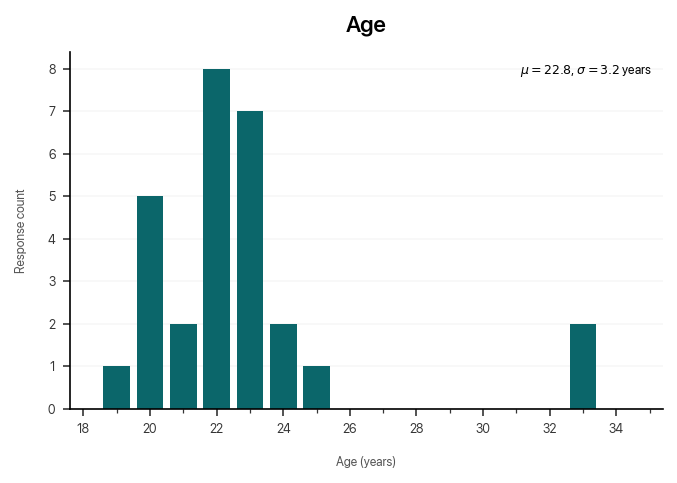

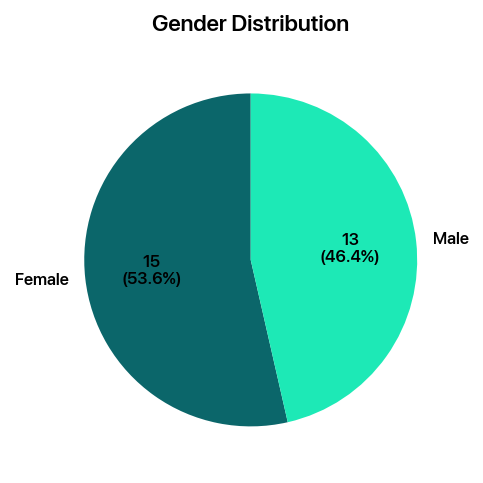

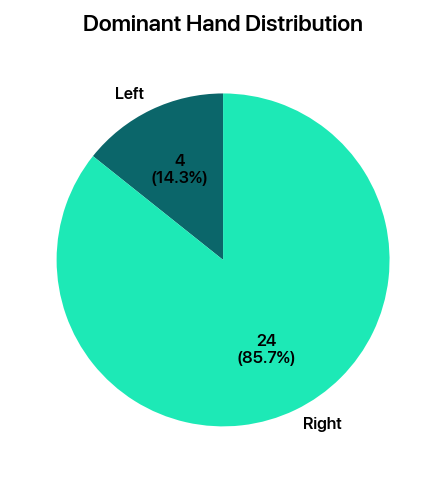

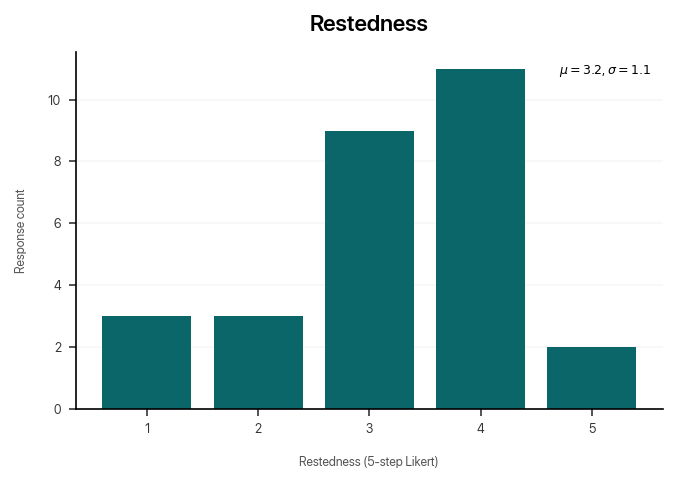

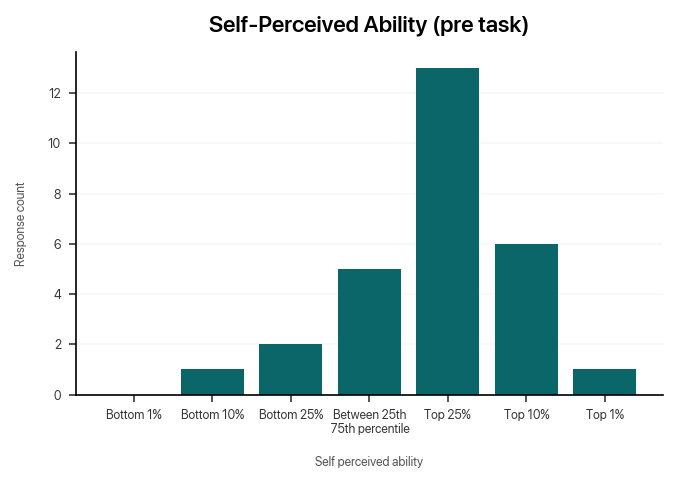

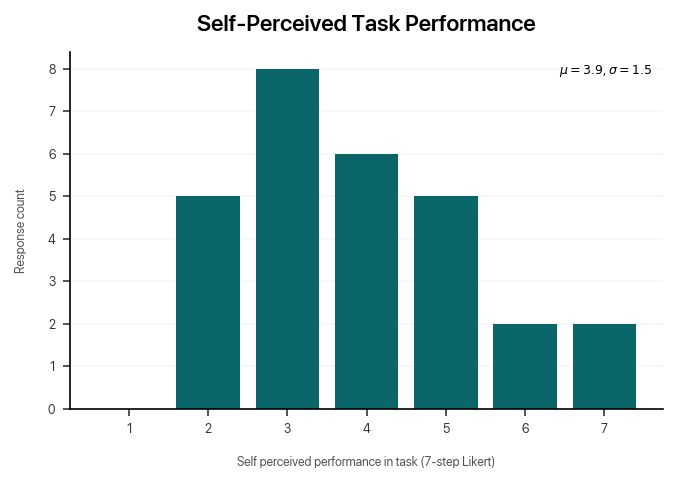

In [166]:
plt.figure()
plt.hist(survey["Age"], bins = 18, range = (18, 36), rwidth=0.8, align = "left")
plt.xlabel("Age (years)")
plt.ylabel("Response count")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.title("Age")
plt.legend(
    handles = [],
    title = f"""$\mu = {survey["Age"].mean():.1f}$, $\sigma = {survey["Age"].std():.1f}$ years""",
    loc = "upper right",
)
plt.tight_layout()

plt.figure()
by_gender = survey.groupby("Gender")
plt.pie(
    by_gender.size(), 
    labels = by_gender.groups.keys(), 
    autopct=lambda proportion: f"{round(len(survey) * proportion / 100)}\n({proportion:.1f}%)",
    textprops = dict(fontsize = 8, fontweight = 600),
    startangle = 90,
)
plt.title("Gender Distribution")
plt.tight_layout()

plt.figure()
by_hand = survey.groupby("DominantHand")
plt.pie(
    by_hand.size(), 
    labels = by_hand.groups.keys(), 
    autopct=lambda proportion: f"{round(len(survey) * proportion / 100)}\n({proportion:.1f}%)",
    textprops = dict(fontsize = 8, fontweight = 600),
    startangle = 90,
)
plt.title("Dominant Hand Distribution")
plt.tight_layout()

plt.figure()
plt.hist(survey["Restedness"], bins = 5, range = (1, 5 + 1), rwidth=0.8, align = "left")
plt.xlabel("Restedness (5-step Likert)")
plt.ylabel("Response count")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.margins(x = 0.05)
plt.title("Restedness")
plt.legend(
    handles = [],
    title = f"""$\mu = {survey["Restedness"].mean():.1f}$, $\sigma = {survey["Restedness"].std():.1f}$""",
    loc = "upper right",
)
plt.tight_layout()

plt.figure()
plt.xlabel("Self perceived ability")
plt.ylabel("Response count")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.margins(x = 0.05)
plt.title("Self-Perceived Ability (pre task)")
hist, bin_edges = np.histogram(
    survey["SelfPerceivedAbilityPercentile"], 
    [0] + list(performance_bracket_mapping.values())
)
plt.bar(range(len(hist)), hist, width=0.8) 
plt.xticks(range(len(hist)), ["\n".join(key.split(" and")) if "and" in key else key for key in performance_bracket_mapping.keys()])
plt.tight_layout()

plt.figure()
plt.hist(survey["SelfPerceivedPerformance"], bins = 7, range = (1, 7 + 1), rwidth=0.8, align = "left")
plt.xlabel("Self perceived performance in task (7-step Likert)")
plt.ylabel("Response count")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.margins(x = 0.05)
plt.title("Self-Perceived Task Performance")
plt.legend(
    handles = [],
    title = f"""$\mu = {survey["SelfPerceivedPerformance"].mean():.1f}$, $\sigma = {survey["SelfPerceivedPerformance"].std():.1f}$""",
    loc = "upper right",
)
plt.tight_layout()